<a href="https://colab.research.google.com/github/kemmie-c/MMFADataset/blob/main/%E4%BD%9C%E6%A5%AD1_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re

# ===== 讀取 Excel =====
excel_file_path = '/content/train_Data.xlsx'
df = pd.read_excel(excel_file_path)
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df['content_cleaned']
y = df['label']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=100,  # 100 samples for the test set
    stratify=y,     # Stratify based on the 'label' column
    random_state=42 # for reproducibility
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nDistribution of labels in y_train:")
display(y_train.value_counts())

print("\nDistribution of labels in y_test:")
display(y_test.value_counts())

In [ ]:
import jieba

def segment_text(text):
    if isinstance(text, str):
        # Perform word segmentation
        seg_list = jieba.cut(text, cut_all=False) # cut_all=False for accurate mode
        return " ".join(seg_list)
    else:
        return ""

# Apply word segmentation to the cleaned content in both training and testing sets
X_train_segmented = X_train.apply(segment_text)
X_test_segmented = X_test.apply(segment_text)

print("Original X_train sample:")
display(X_train.head())

print("\nSegmented X_train sample:")
display(X_train_segmented.head())

print("\nOriginal X_test sample:")
display(X_test.head())

print("\nSegmented X_test sample:")
display(X_test_segmented.head())

In [ ]:
# ✅ 改進 1: 使用 TF-IDF 特徵
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, max_features=5000)  # 限制特徵數量避免過大
X_train_bow = vectorizer.fit_transform(X_train_segmented)
X_test_bow = vectorizer.transform(X_test_segmented)

print("Shape of X_train_bow:", X_train_bow.shape)
print("Shape of X_test_bow:", X_test_bow.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# ✅ 改進 2: 增加隱藏層 + Dropout
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_bow.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Train the model
y_train_numerical = y_train.astype(int)
y_test_numerical = y_test.astype(int)
X_train_bow_dense = X_train_bow.todense()

# ✅ 改進 3: 加入 EarlyStopping 防止 overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train_bow_dense, y_train_numerical,
                    epochs=10,         # 增加訓練次數
                    shuffle=True,       # 改成 True 打亂資料
                    batch_size=64,      # 減小 batch 提高學習穩定度
                    validation_split=0.3,
                    callbacks=[early_stop])

## (5) 模型評估⭐️⭐️⭐️

In [ ]:
# Evaluate the model on the test set
X_test_bow_dense = X_test_bow.todense()

loss, accuracy = model.evaluate(X_test_bow_dense, y_test_numerical)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# 新增
# Convert y_test to numerical dtype if it hasn't been already
y_true = y_test.values.astype('float32')
display("y_true =", y_true)

# Convert sparse test matrix to dense for evaluation
X_test_bow_dense = X_test_bow.todense()

# Calculate predictions (y_pred) for the test set
y_pred_prob = model.predict(X_test_bow_dense).ravel().astype('float32')
display("y_pred_prob =", y_pred_prob)

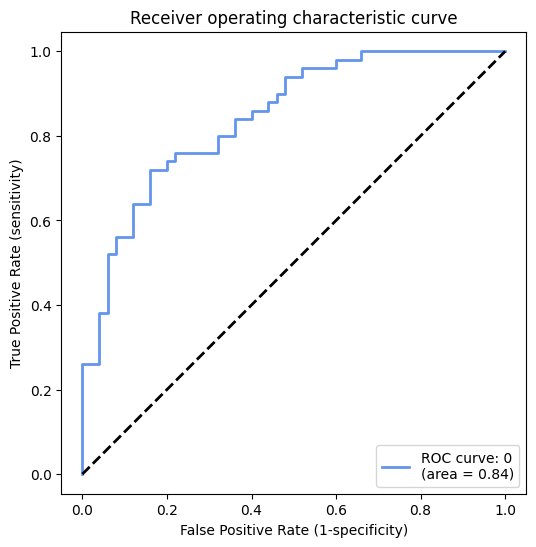

In [ ]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
from sklearn.metrics import roc_curve, auc

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
fpr, tpr, _ = roc_curve(y_true[:], y_pred_prob[:])
roc_auc = auc(fpr, tpr)

# plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.plot(fpr, tpr, color='cornflowerblue', lw=2,
            label=f'ROC curve: {0}\n(area = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Receiver operating characteristic curve')
ax.legend(loc="lower right")
plt.show()

In [ ]:
# 信心值超過多少預測為陽性
threshold = 0.5
y_pred = y_pred_prob > threshold
display("y_true =", y_true.astype(int))
display("y_pred =", y_pred.astype(int))

'y_true ='

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1])

'y_pred ='

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
y_pred_prob = model.predict(X_test_bow_dense)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
cm = confusion_matrix(y_test_numerical, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['True Negative (0)', 'True Positive (1)'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
# 自訂意 cost function [TODO]
def cost_fn(y_true, y_pred_prob, threshold=0.5):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred_prob > threshold)
    cost = (tp * -10000) + (fn * -200000) + (fp * -10000) + (tn * 200000)

    return int(cost)

# function test:
cost_fn(y_true, y_pred_prob, threshold=0.5)

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test_numerical, y_pred)
print("Classification Report:")
print(report)

Shape of X_train: (1442,)
Shape of X_test: (100,)
Shape of y_train: (1442,)
Shape of y_test: (100,)

Distribution of labels in y_train:


,count
label,
1,721
0,721



Distribution of labels in y_test:


,count
label,
0,50
1,50


Original X_train sample:


,content_cleaned
895,打破年齡設限‧看見青春立體。0AAA。撐補成分歲月細節一股腦地顯現在外表。支‧撐‧力000A...
187,兒童專科舒緩情緒消化提升敏感調理全台最足量健康食品變聰明變聰明的零食天然增加學習效率針對敏弱...
1440,0%增稠000%香料000%色素。維持消化道機能。日本專利膳食纖維多元益生菌。黃金比例口感細...
601,小胸救星升AAA不難。小胸&大胸女孩是不是有以下煩惱。撐不起衣服。哺乳後ㄋㄋ大縮水。美型拉提...
69,便秘救星、減肥聖品、減肥瘦瘦水、便祕必喝、便祕必喝、被封是減肥&解便秘聖品、便祕必喝、減肥聖...



Segmented X_train sample:


,content_cleaned
895,打破 年齡 設限 ‧ 看見 青春 立體 。 0AAA 。 撐補 成分 歲 月 細節 一股 腦...
187,兒童 專科 舒緩 情緒 消化 提升 敏感 調理 全台 最 足量 健康 食品 變聰明 變聰明 ...
1440,0% 增稠 000% 香料 000% 色素 。 維持 消化道 機能 。 日本 專利 膳食 纖...
601,小胸 救星 升 AAA 不難 。 小胸 & 大胸 女孩 是不是 有 以下 煩惱 。 撐 不起...
69,便秘 救星 、 減肥 聖品 、 減 肥瘦 瘦水 、 便 祕 必 喝 、 便 祕 必 喝 、 ...



Original X_test sample:


,content_cleaned
1078,享受尚好生活。享食尚健字號甘甘好活力加值組黃金組合甘甘好膠囊衛部健食字第AAA000號專為您...
1318,超模之鑰。防溢方案。官網000下殺000典悅生醫AAA搭配營養素幫助調節生理機能維持身體健康...
1348,商品。0益生菌益生質互利共生。0項全球專利後生元調整體質。幫助維持消化道機能。0色素、0人工...
89,抗藍光護眼軟糖。不如就給他吃抗藍光軟糖吧。吸收強光、過濾藍光、保護眼睛。適合族群:長時間盯著...
718,體力、美力一次擁有。0種AAA群完整組合。0合000美妍配方讓妳青春好自信。長效緩釋持續釋放...



Segmented X_test sample:


,content_cleaned
1078,享受 尚好 生活 。 享食 尚健字號 甘甘好 活力 加值 組黃金 組合 甘甘好 膠囊 衛部 ...
1318,超模 之 鑰 。 防溢 方案 。 官網 000 下 殺 000 典悅 生醫 AAA 搭配 營...
1348,商品 。 0 益生菌 益生質 互利 共生 。 0 項 全球 專利後生 元 調整 體質 。 幫...
89,抗藍光護 眼軟 糖 。 不如 就給 他 吃 抗藍光 軟糖 吧 。 吸收 強光 、 過濾 藍光...
718,體力 、 美力 一次 擁有 。 0 種 AAA 群 完整 組合 。 0 合 000 美妍 配...


Shape of X_train_bow: (1442, 5000)
Shape of X_test_bow: (100, 5000)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6764 - loss: 0.6851 - val_accuracy: 0.9677 - val_loss: 0.6349
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9581 - loss: 0.5859 - val_accuracy: 0.9723 - val_loss: 0.4294
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9907 - loss: 0.3234 - val_accuracy: 0.9723 - val_loss: 0.1993
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9948 - loss: 0.1182 - val_accuracy: 0.9769 - val_loss: 0.1101
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9987 - loss: 0.0385 - val_accuracy: 0.9792 - val_loss: 0.0879
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 0.9769 - val_loss: 0.0812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9769 - val_loss: 0.0792
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9769 - v

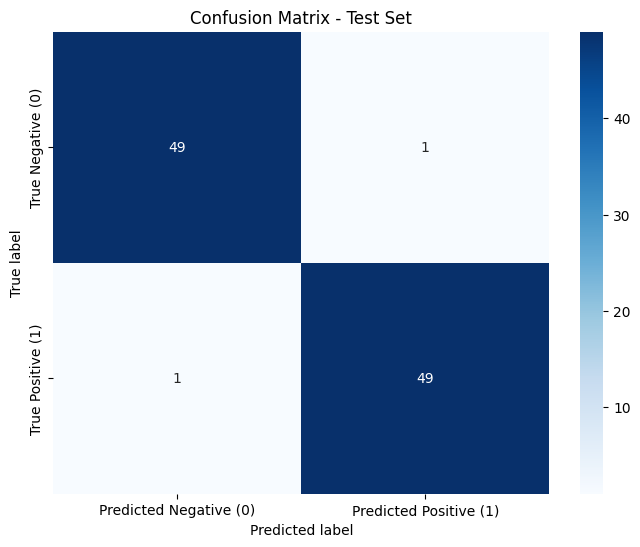

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      0.98      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

[True Negative]
Text: 優德莎莉月月美生理飲000AAA000包盒無中藥成分生理期專屬飲品。碧容健、膳食纖維、紅棗添加。A國家品質標章認證。優德莎莉惜妳飲沛養000AAA000包入多樣營養素符合小產後調理所需。拆封即飲。免沖泡免熬煮。0%全隱密包裝。無相關字眼。優德莎莉惜妳飲淳補000AAA000包入多樣營養素符合小產後調理所需。
True Label: 0
Pred Label: 0

[True Positive]
Text: 減肥產品飽感減少食慾。每日一顆輕鬆瘦。新陳代謝循環較慢者。服用後會降低食慾體重下降容易接受飲食控制從而達到體重的減輕。
True Label: 1
Pred Label: 1

[False Negative]
Text: 鈣質。而且不只影響我們的行動力、小朋友的成長狀況甚至也跟睡眠、情緒有相關。海藻鈣結構為蜂窩多孔性結構提供更好的吸收率可以高達000%。添加日本專利AAA水解蛋黃粉可以協同鈣作用。紐西蘭酪蛋白水解產物可幫助鈣質在消化道形成可溶性狀態促進鈣吸收。市售最高海藻鈣。
True Label: 1
Pred Label: 0

[False Positive]
Text: 國民戲劇男神李國毅代言科懋利脂受。百位產後媽咪試用調查000%排便順暢滿意。百位產後媽咪試用調查000%產品使用滿意。可以好好吃飯的秘密武器利脂受代謝AAA。餐前一包利脂受000

In [ ]:
import numpy as np
X_test_dense = X_test_bow.toarray()
y_test_numerical = y_test.astype(int).values

y_pred_prob = model.predict(X_test_dense)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

results = pd.DataFrame({
    "text": X_test,
    "true": y_test_numerical,
    "pred": y_pred
})

tn = results[(results.true == 0) & (results.pred == 0)]
tp = results[(results.true == 1) & (results.pred == 1)]
fn = results[(results.true == 1) & (results.pred == 0)]
fp = results[(results.true == 0) & (results.pred == 1)]

examples = []
if len(tn) > 0: examples.append(("True Negative", tn.sample(1)))
if len(tp) > 0: examples.append(("True Positive", tp.sample(1)))
if len(fn) > 0: examples.append(("False Negative", fn.sample(1)))
if len(fp) > 0: examples.append(("False Positive", fp.sample(1)))

if len(examples) < 5:
    more_samples = results.sample(5 - len(examples))
    for _, row in more_samples.iterrows():
        examples.append(("Random", row.to_frame().T))

for label, row in examples:
    print(f"\n[{label}]")
    print("Text:", row["text"].values[0])
    print("True Label:", row["true"].values[0])
    print("Pred Label:", row["pred"].values[0])


## (6) 預測資料⭐️⭐️⭐️

In [ ]:
import pandas as pd

# === 載入測試資料 ===
# 假設檔案放在同一個資料夾底下
predict_df = pd.read_csv("predict_sample.csv")
predict_df

In [ ]:
# ====== 1. 對預測資料進行斷詞(如同3A) ======
predict_df["content_segmented"] = predict_df["content_cleaned"].apply(segment_text)

# ====== 2. 使用訓練過的 vectorizer 進行特徵轉換(如同3B) ======
# 只能用 transform，不能用 fit 或 fit_transform
# 因為 vectorizer 的詞彙表已經在訓練階段確定，不能改變
X_predict_bow = vectorizer.transform(predict_df["content_segmented"])

# ====== 3. 轉換成 Dense Tensor (如果4有進行此步驟) ======
X_predict_dense = X_predict_bow.todense()

# ====== 4. 使用訓練好的模型進行預(假設閾值為0.5) ======
y_proba = model.predict(X_predict_dense).ravel()   # 機率 0~1
y_pred = (y_proba >= 0.5).astype(int)              # 二元分類結果 0/1

# ====== 5. 輸出成 CSV 檔案 ======
output_df = pd.DataFrame({
    "ID": predict_df["ID"],
    "label": y_pred
})

output_file = "group2_陳萱鎂_answer_v0.csv"
output_df.to_csv(output_file, index=False, encoding="utf-8-sig")
output_df